 **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
from clearml import Task
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch 

In [ ]:
task = Task.init(project_name='Experimentation', task_name='Albu_test_overfit_aug')


In [ ]:
# Task.get_task(project_name='great project', task_name='experiment1')
# task.mark_completed()
task.close()

In [2]:
DATA_DIR = './data/CamVid/'

# # load repo with data if it is not exists
# if not os.path.exists(DATA_DIR):
#     print('Loading data...')
#     os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
#     print('Done!')

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# x_test_dir = os.path.join(DATA_DIR, 'test_ood')
# y_test_dir = os.path.join(DATA_DIR, 'testannot_ood')

Debugging: Did image load?

In [ ]:

#Testing 


# import matplotlib.image as mpimg



# # List all image files in the directory
# image_files = [f for f in os.listdir(y_valid_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# # Loop through the image files and display them
# for image_file in image_files:
#     # Create the full file path
#     image_path = os.path.join(y_valid_dir, image_file)
    
#     # Read and display the image using Matplotlib
#     img = mpimg.imread(image_path)
#     plt.figure()
#     plt.imshow(img)
#     plt.title(image_file)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()


### Dataloader




In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision.transforms import v2


In [5]:
from clearml import PipelineDecorator



# @PipelineDecorator.component(return_values=['image'])
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    import os
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()



    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x



In [6]:
from PIL import Image


# @PipelineDecorator.component(cache=False,return_values=['image','mask'])    
# classes for data loading and preprocessing
class Dataset:
  
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    

    
    def __getitem__(self, i):
       
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # print(mask)
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
            
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    





In [ ]:


from PIL import Image



class CamVidDataset(torch.utils.data.Dataset):


    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None, classes=None):
        
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in os.listdir(images_dir)]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in os.listdir(masks_dir)]

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.classes = classes



    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.images_fps[idx]).convert("RGB")
        mask = Image.open(self.masks_fps[idx])

        # Filter masks based on self.class_values
        if self.class_values:
            mask = np.array(mask)
            filtered_mask = np.zeros_like(mask)
            for cls_value in self.class_values:
                class_mask = (mask == cls_value)
                filtered_mask = np.logical_or(filtered_mask, class_mask)
            mask = Image.fromarray(filtered_mask.astype('uint8') * 255)


       
      

        # Apply augmentation if provided
        if self.augmentation:
            # Convert to PIL Image before augmentation
            image, mask = self.augmentation(image, mask)

            # Convert augmented PIL Image back to NumPy array
            image = np.array(image)
            mask = np.array(mask)

            mask = np.expand_dims(mask, axis=-1)

        # Apply preprocessing if provided
        if self.preprocessing:
            image = self.preprocessing(image)

        # image = torch.from_numpy(image).permute(2,0,1).float()
        #mask = mask.transpose(2, 0, 1)  # Transpose the dimensions
        # mask = torch.from_numpy(mask).float()


        return image, mask








    def __len__(self):
        return len(self.ids)



  # if self.augmentation:
        # # Convert to PIL Image before augmentation
        #         image, mask = self.augmentation(image, mask)

        #         # Convert augmented PIL Image back to NumPy array
        #         image = np.array(image)
        #         mask = np.array(mask)

        #         # Apply preprocessing if provided
        #         if self.preprocessing:
        #             image = self.preprocessing(image)

        #         image = torch.from_numpy(image).permute(2, 0, 1).float()

        #         # Convert the mask to the format (1, H, W)
        #         mask = mask[np.newaxis, ...].astype(np.float32)
        #         mask = torch.from_numpy(mask)

In [ ]:
from PIL import Image
# import numpy as np
# import torch

class CamVidDataset(torch.utils.data.Dataset):
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None, classes=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in os.listdir(images_dir)]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in os.listdir(masks_dir)]

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.classes = classes

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.images_fps[idx]).convert("RGB")  # Ensure RGB channel order
        mask = Image.open(self.masks_fps[idx])


        # Filter masks based on self.class_values
        if self.class_values:
            filtered_mask = np.zeros_like(mask, dtype=np.uint8)
            for cls_value in self.class_values:
                class_mask = (mask == cls_value)
                filtered_mask = np.logical_or(filtered_mask, class_mask)
            mask = filtered_mask

        if self.augmentation:
            # Convert to PIL Image before augmentation
            image, mask = self.augmentation(image, mask)

            # Convert augmented PIL Image back to NumPy array
            image = np.array(image)
            mask = np.array(mask)

            mask = np.expand_dims(mask, axis=-1)

        # Apply preprocessing if provided
        if self.preprocessing:
            image = self.preprocessing(image)

        return image, mask

    def __len__(self):
        return len(self.ids)


In [ ]:
# import torchvision



# class CustomAugMixPreprocessing:
#     def __init__(self, severity=3, mixture_width=3, alpha=1.0):
#         self.augmix = torchvision.transforms.AugMix(severity=severity, mixture_width=mixture_width, alpha=alpha)

#     def __call__(self, image, mask):
#         # Apply AugMix to image
#         augmix_image = self.augmix(image)

#         return augmix_image, mask



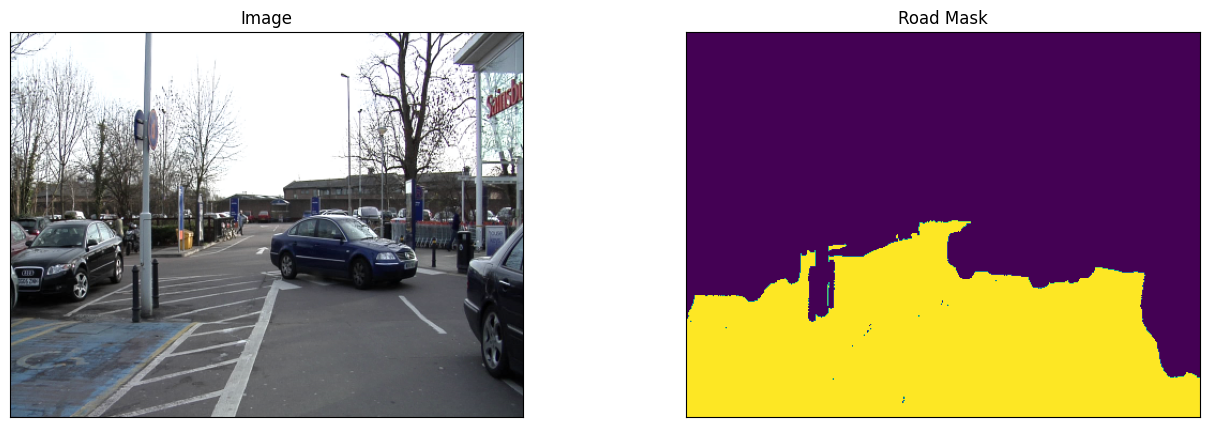

image shape is:  (360, 480, 3) mask shape is :  (360, 480, 1)


In [7]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['road'])

image, mask = dataset[150] # get some sample
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    #pavement_mask=mask[..., 1].squeeze(),
    #background_mask=mask[..., 2].squeeze(),
)

print("image shape is: ", image.shape,"mask shape is : ", mask.shape) 

In [ ]:
# dataset = CamVidDataset(x_train_dir, y_train_dir, classes=['road'])

# image, mask = dataset[170] # get some sample
# visualize(
#     image=image, 
#     road_mask=mask[..., 0].squeeze(),
#     #pavement_mask=mask[..., 1].squeeze(),
#     #background_mask=mask[..., 2].squeeze(),
# )

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  

Albumentations pipeline


In [ ]:

#from CAP_augmentation.src.cap_aug import CAP_Albu
import albumentations as albu
# from deepaugment.deepaugment import DeepAugment

In [ ]:
# @PipelineDecorator.component(return_values=['train_transform_aug'])

import PIL

def get_training_augmentation():

    import os
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        #albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.9),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),



        # # CAP_Albu(p=1, 
        # #        source_images=x_train_dir, 
        # #        n_objects_range=[10,20], 
        # #        h_range=[100,101],
        # #        x_range=[500, 1500],
        # #        y_range=[600 ,1000],
        # #        class_idx=1),
            

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # albu.Lambda(image=print_shape, mask= print_shape),
    ]
    return albu.Compose(train_transform)

    



def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
        # albu.Lambda(image=print_shape, mask= print_shape)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        # albu.Lambda(image=print_shape, mask= print_shape),
        albu.Lambda(image=to_tensor, mask=to_tensor),
        
    ]
    return albu.Compose(_transform)



# Define a function to print the shape of the input
def print_shape(x, **kwargs):
    if isinstance(x, PIL.Image.Image):
        print("Image size:", x.size)
    elif isinstance(x, np.ndarray):
        print("Array shape:", x.shape)
    return x

Debug shape

Randaugment trial

In [ ]:
from MuarAugment.muar.augmentations import AlbumentationsRandAugment
from albumentations.pytorch import ToTensorV2


def get_transform(rand_augment, stage='train', size=(28,28)):
        if stage == 'train':
            resize_tfm = [albu.Resize(*size)]
            
            rand_tfms = rand_augment() # returns a list of transforms

            tensor_tfms = [albu.Normalize(), ToTensorV2()]
            return albu.Compose(resize_tfm + rand_tfms + tensor_tfms)

        elif stage=='valid':
            resize_tfm = [albu.Resize(*size)]
            tensor_tfms = [albu.Normalize(), ToTensorV2()]
            return albu.Compose(resize_tfm + tensor_tfms)




class RandAugmentDataset(Dataset):
    def __init__(self, data, stage='train', image_size=(28,28), N_TFMS=0, MAGN=0):
        super().__init__()
        self.images,self.labels = list(zip(*data))
        self.stage, self.size = stage, image_size
        self.N_TFMS, self.MAGN = N_TFMS, MAGN
        if stage == 'train':
            self.rand_augment = AlbumentationsRandAugment(N_TFMS, MAGN)
        else: 
            self.rand_augment = None
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image,label = self.images[idx],self.labels[idx]
        image = np.array(image)[:,:,None]
        image = np.repeat(image, 3, axis=2) # image must be 3 channels
        
        transform = get_transform(self.rand_augment, self.stage, self.size)
        augmented = transform(image=image)['image']
        return augmented, torch.LongTensor([label])
    



   

Torchvision.transforms pipeline

In [ ]:

# from albumentations.pytorch import ToTensorV2


def get_training_augmentation():
    train_transform = v2.Compose([
        v2.RandomHorizontalFlip(),
        v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.RandomApply([v2.GaussianBlur(3, sigma=0.5)], p=0.2),
        v2.RandomApply([v2.RandomPerspective(distortion_scale=0.7)], p=0.2),
        v2.RandomResizedCrop((320, 320)),
    ])
    return train_transform

def get_validation_augmentation():
    test_transform = v2.Compose([
        v2.Pad(padding=(0,12)),
    ])
    return test_transform




def to_tensor(x,**kwargs):
    return x.transpose(2, 0, 1).astype('float32')





def custom_preprocessing(image, mask, preprocessing_fn):
    # Transpose the image to the desired shape (3, 384, 480)
    #image = np.transpose(image, (2, 0, 1))
    # mask = cv2.resize(mask, (480, 384), interpolation=cv2.INTER_NEAREST)
    # mask = np.expand_dims(mask, axis=0)  # Add a channel dimension to the mask
    # print("image shape is: ", image.shape,"mask shape is : ", mask.shape) 
    # Apply the preprocessing function to the image
    image = preprocessing_fn(image)

    mask = np.transpose(mask, (2, 0, 1))
    mask = np.expand_dims(mask, axis=0)    # Resize the mask to the desired shape (384, 480)
    mask = v2.ToTensor()(mask)
   

    return image, mask

def get_preprocessing(preprocessing_fn):
    print("IN Preprocess")

    transform = v2.Compose([
        v2.Lambda(custom_preprocessing),
        v2.ToTensor(),
        
    ])

    return transform






# def get_preprocessing(preprocessing_fn):
#     def transform(sample):
#         # Extract the image and mask from the sample
#         image, mask = sample

#         # Apply preprocessing_fn to the image
#         image = preprocessing_fn(image)

#         # Convert mask to tensor and reshape it (assuming you have a single-channel mask)
#         mask = np.expand_dims(mask, axis=-1)
#         mask = torch.from_numpy(mask).float()

#         return image, mask

#     return transform




In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    # preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'],
) 

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[35]
    visualize(augmentedimage=image, mask=mask)
    print("image shape is: ", image.shape,"mask shape is : ", mask.shape )

In [ ]:

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_validation_augmentation(), 
    #preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'],
) 

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[35]
    print("image shape is: ", image.shape,"mask shape is : ", mask.shape )
    visualize(augmentedimage=image, mask=mask)

# model and training

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# @PipelineDecorator.component(return_values=['Training'])
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation=ACTIVATION,      # activation function, default is None
    classes=len(CLASSES),
                                   # define number of output labels
)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    # aux_params=aux_params
    
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'],
) 

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[35]
    print("image shape is: ", image.shape,"mask shape is : ", mask.shape )
    visualize(augmentedimage=image, mask=mask)

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

Debug dataloader

In [ ]:
for batch_idx, (images, masks) in enumerate(train_loader):
    # Check the shapes of images and masks
    print(f"Batch {batch_idx + 21}:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    
    # Check the data types (should be torch tensors)
    print(f"Images data type: {type(images)}")
    print(f"Masks data type: {type(masks)}")
    
    # Optionally, you can visualize or print a sample image and mask
    if batch_idx == 0:
        sample_image = images[0]  # Take the first image in the batch
        sample_mask = masks[0]    # Take the corresponding mask
        # Visualize or print the sample image and mask to inspect their content
        # ...

    # Break the loop after inspecting a few batches
    if batch_idx >= 2:  # Adjust the number of batches to inspect as needed
        break

In [ ]:
for batch_idx, (images, masks) in enumerate(valid_loader):
    # Check the shapes of images and masks
    print(f"Batch {batch_idx + 21}:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    
    # Check the data types (should be torch tensors)
    print(f"Images data type: {type(images)}")
    print(f"Masks data type: {type(masks)}")
    
    # Optionally, you can visualize or print a sample image and mask
    if batch_idx == 0:
        sample_image = images[0]  # Take the first image in the batch
        sample_mask = masks[0]    # Take the corresponding mask
        # Visualize or print the sample image and mask to inspect their content
        # ...

    # Break the loop after inspecting a few batches
    if batch_idx >= 2:  # Adjust the number of batches to inspect as needed
        break

In [ ]:

from segmentation_models_pytorch import utils


loss = smp.utils.losses.DiceLoss()

# loss = smp.losses.SoftBCEWithLogitsLoss()
# loss.__name__ = 'soft_bce'

# loss = smp.losses.TverskyLoss(mode = 'binary', from_logits= True)   
# loss.__name__ = 'Twersky_Loss'

# loss = smp.losses.LovaszLoss(mode = 'binary', from_logits=True)   
# loss.__name__ = 'Lovasz_Loss'

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
    # torch.optim.SGD( dict(params=model.parameters(), lr=0.1,momentum=0.9,weight_decay=0.0005))
])


# optimizer = torch.optim.SGD([ 
#     # {'params': model.parameters(), 'lr': 0.0001},  # Adam for other parameters
#     {'params': model.parameters(), 'lr': 0.1, 'weight_decay': 0.0005, 'momentum': 0.9}  # SGD for model.parameters() with specific lr, weight_decay, and momentum
# ])

#task.connect(mutable = optimizer)

In [ ]:
print(torch.__version__)

In [ ]:
task.connect(mutable=loss,name='loss')

In [ ]:
task.connect(mutable=metrics,name='metrics')

In [ ]:
task.connect(mutable = model,name='Model')

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for computations.")
else:
    print("CUDA is not available. Using CPU for computations.")

In [ ]:
# train model for 40 epochs

max_score = 0

# logger = task.get_logger()
for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    print(train_logs)

    # logger.report_scalar('Dice_loss train', 'model_output', iteration=i, value=train_logs['Dice_loss'])
    # logger.report_scalar('IoU score train', 'model_output', iteration=i, value=train_logs['iou_score'])
    # logger.report_scalar('Dice_loss valid', 'model_output', iteration=i, value=valid_logs['Dice_loss'])
    # logger.report_scalar('IoU score valid', 'model_output', iteration=i, value=valid_logs['iou_score'])
    
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 40:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
# load best saved checkpoint
best_model = torch.load('best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)
# logger.report_scalar('Test IoU', 'model_output', iteration=i, value=logs['iou_score'])
# logger.report_scalar('Test Dice Loss', 'model_output', iteration=i, value=logs['dice_loss'])

Predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
print(test_dataset)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    # image_vis = np.array(test_dataset_vis[n][0]).astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
# Initialize variables to accumulate predictions and ground truth masks
all_pr_masks = []
all_gt_masks = []

# Iterate through the entire test dataset
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    # Accumulate the predictions and ground truth masks
    all_pr_masks.append(pr_mask)
    all_gt_masks.append(gt_mask)

# Convert the lists to tensors
all_pr_masks = torch.from_numpy(np.array(all_pr_masks)).float()

all_gt_masks = torch.from_numpy(np.array(all_gt_masks)).long()
print(all_gt_masks.shape)
print(all_pr_masks.shape)

In [ ]:
from torchmetrics import ConfusionMatrix


tp, fp, fn, tn = smp.metrics.get_stats(all_pr_masks, all_gt_masks, mode='binary', threshold=0.5)

# Create and plot the confusion matrix
conf_mat = ConfusionMatrix(task="binary", num_classes=2)
conf_matrix = conf_mat(all_pr_masks, all_gt_masks)
conf_mat.plot()
plt.show()

In [ ]:
from torchmetrics import Recall, Accuracy,F1Score, FBetaScore,JaccardIndex


# Calculate Intersection over Union (IoU)
iou_score = JaccardIndex(task = "binary",num_classes=2)  # For a binary classification task
iou_score.update(all_pr_masks,all_gt_masks)
iou = iou_score.compute().item()



# Calculate F1 score
f1_metric = F1Score(task="binary",num_classes=2)  # For a binary classification task
f1_metric.update(all_pr_masks,all_gt_masks)
f1_score = f1_metric.compute().item()

# Calculate F2 score
f2_metric = FBetaScore(task="binary",beta=2.0, num_classes=2)  # For a binary classification task
f2_metric.update(all_pr_masks,all_gt_masks)
f2_score = f2_metric.compute().item()

# Calculate Recall
recall_metric = Recall(task = "binary",num_classes=2)  # For a binary classification task
recall_metric.update(all_pr_masks,all_gt_masks)
recall = recall_metric.compute().item()

# Calculate Accuracy
accuracy_metric = Accuracy(task = "binary",num_classes=2)  # For a binary classification task
accuracy_metric.update(all_pr_masks,all_gt_masks)
accuracy = accuracy_metric.compute().item()

# Print or use the calculated metrics as needed
print("IoU:", iou)
print("F1 Score:", f1_score)
print("F2 Score:", f2_score)
print("Recall:", recall)
print("Accuracy:", accuracy)

Metrics for generalization

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,auc
import matplotlib.pyplot as plt

# Assuming y_true is the ground truth binary mask and y_prob is the probability map
fpr, tpr, thresholds = roc_curve(all_gt_masks.flatten(), all_pr_masks.flatten())
auroc = roc_auc_score(all_gt_masks.flatten(), all_pr_masks.flatten())


desired_tpr = 0.95  # Set the desired TPR value
index = next(i for i, value in enumerate(tpr) if value >= desired_tpr)

fpr_at_desired_tpr = fpr[index]*100

print(f"FPR at {desired_tpr * 100}% TPR: {fpr_at_desired_tpr}")



# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'AUROC Score: {auroc:.2f}')

In [ ]:
precision,recall_val, thresholds = precision_recall_curve(all_gt_masks.flatten(), all_pr_masks.flatten())
aupr = auc(recall_val,precision)
print("AUPR: " , aupr)
plt.figure(figsize=(8, 6))
plt.plot(recall_val, precision, color='blue', lw=2, label='Precision-Recall Curve (AUPR = {:.2f})'.format(aupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.legend(loc='lower right')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.05])
plt.show()

In [ ]:
task.mark_completed()